In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

In [ ]:
df = pd.read_csv('ev_blast_dataset.csv')
print(df.shape)
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(919, 9)


,Battery_Type,Poor_Cell_Design,External_Abuse,Poor_Battery_Design,Short_Circuits,Temperature,Overcharge_Overdischarge,Battery_Maintenance,Battery_Health
0,Lead-Acid,0,Yes,0,0,23.633881,Over-discharge,No,Moderate
1,Lithium-Ion,1,No,1,0,32.816012,Overcharge,No,Moderate
2,Lead-Acid,0,No,1,0,28.209703,Over-discharge,No,Moderate
3,Lead-Acid,0,No,0,1,33.731964,Over-discharge,Yes,Blast
4,Lead-Acid,1,Yes,1,1,44.063272,Over-discharge,No,Blast


In [ ]:
target_col = "Battery_Health"
X = df.drop(columns=[target_col])
y = df[target_col]

In [ ]:
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

In [ ]:
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

In [ ]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])

In [ ]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

In [ ]:
xgb = XGBClassifier(
    objective="multi:softmax",
    num_class=len(np.unique(y_train_enc)),
    eval_metric="mlogloss",
    tree_method="hist",
    learning_rate=0.1,
    n_estimators=400,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=RANDOM_STATE
)

In [ ]:
pipe = Pipeline([("preprocessor", preprocessor), ("model", xgb)])

In [ ]:
pipe.fit(X_train, y_train_enc)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Poor_Cell_Design',
                                                   'Poor_Battery_Design',
                                                   'Short_Circuits',
                                                   'Temperature']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Battery_Type',
                                                   'External_Abuse',
                                                   'Overcharge_Overdischarge',
                                                   'Battery_Maintenance'])])),
                ('model',
                 XGBClassifier(base_score=None, booster=None, ca...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=400, n_jobs=None, num_class=4, ...))])

In [ ]:
y_pred_enc = pipe.predict(X_test)
y_pred = le.inverse_transform(y_pred_enc)

In [ ]:
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average="macro", zero_division=0)
rec = recall_score(y_test, y_pred, average="macro", zero_division=0)
f1 = f1_score(y_test, y_pred, average="macro", zero_division=0)

print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")

Accuracy : 0.9185
Precision: 0.9207
Recall   : 0.9246
F1-score : 0.9218


<Figure size 600x600 with 0 Axes>

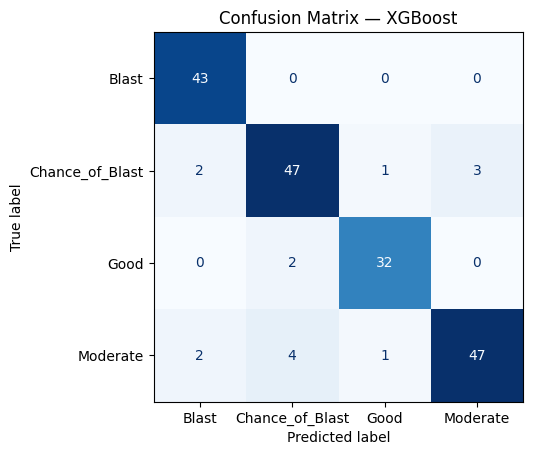

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
plt.figure(figsize=(6,6))
disp.plot(values_format='d', cmap='Blues', colorbar=False)
plt.title('Confusion Matrix — XGBoost')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred, zero_division=0))

                 precision    recall  f1-score   support

          Blast       0.91      1.00      0.96        43
Chance_of_Blast       0.89      0.89      0.89        53
           Good       0.94      0.94      0.94        34
       Moderate       0.94      0.87      0.90        54

       accuracy                           0.92       184
      macro avg       0.92      0.92      0.92       184
   weighted avg       0.92      0.92      0.92       184



In [ ]:
results = []
res_xgb = {
    "model": "XGBoost",
    "accuracy": acc,
    "precision_macro": prec,
    "recall_macro": rec,
    "f1_macro": f1,
    "pipeline": pipe
}
results.append({k: v for k, v in res_xgb.items() if k != "pipeline"})

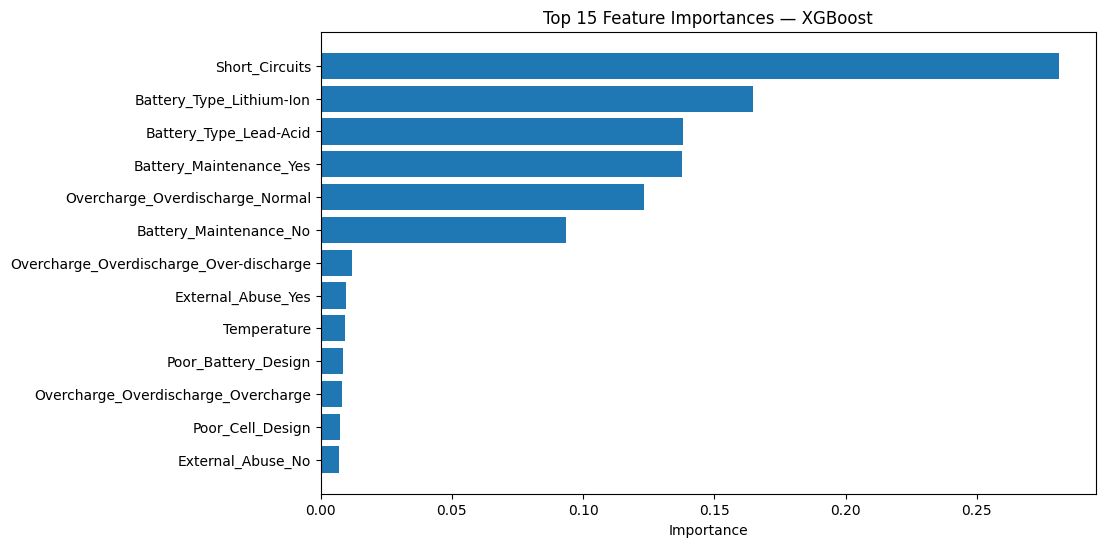

In [32]:
import matplotlib.pyplot as plt

# Get feature names after preprocessing
onehot_cols = pipe.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(cat_cols)
all_features = list(num_cols) + list(onehot_cols)

# Feature importances from XGBoost
importances = pipe.named_steps['model'].feature_importances_

# Sort features by importance
indices = importances.argsort()[::-1]

plt.figure(figsize=(10,6))
plt.barh([all_features[i] for i in indices[:15]], importances[indices][:15])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importances — XGBoost')
plt.gca().invert_yaxis()
plt.show()

/tmp/ipython-input-2438833333.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_pred, order=le.classes_, palette='Set2')


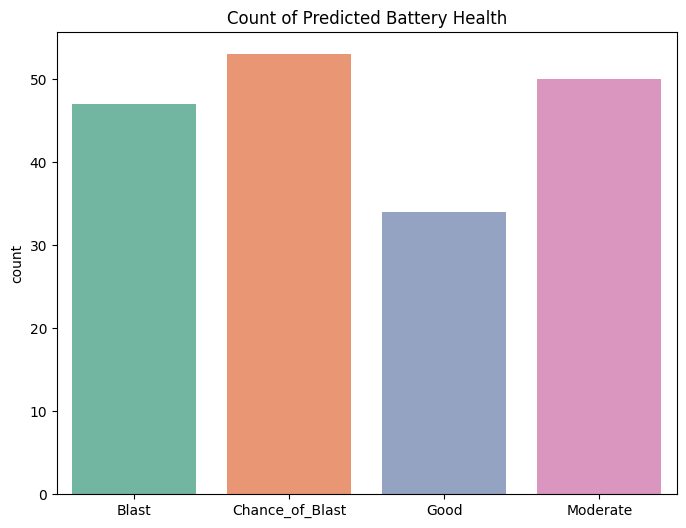

/tmp/ipython-input-2438833333.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_test, order=le.classes_, palette='Set1')


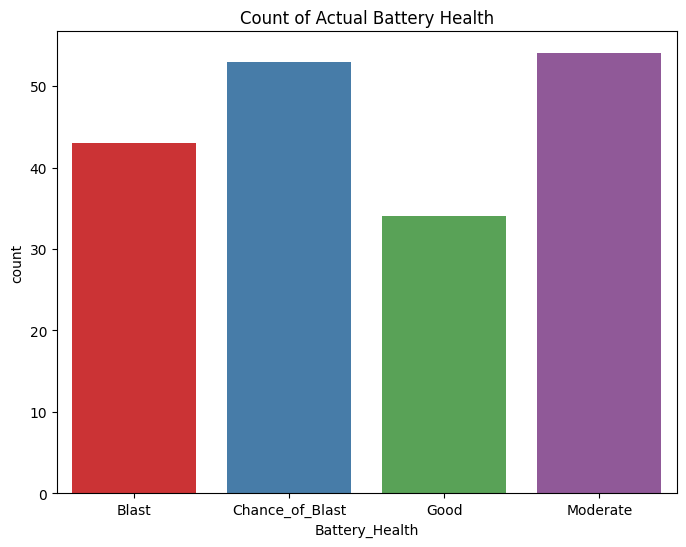

In [30]:
import seaborn as sns

plt.figure(figsize=(8,6))
sns.countplot(x=y_pred, order=le.classes_, palette='Set2')
plt.title('Count of Predicted Battery Health')
plt.show()

plt.figure(figsize=(8,6))
sns.countplot(x=y_test, order=le.classes_, palette='Set1')
plt.title('Count of Actual Battery Health')
plt.show()

In [ ]:
pred_df = X_test.copy()
pred_df['Predicted_Health'] = y_pred

blast_batteries = pred_df[pred_df['Predicted_Health'] == 'Blast']

print(f"Number of batteries predicted to Blast: {len(blast_batteries)}")
blast_batteries.head()

Number of batteries predicted to Blast: 47


,Battery_Type,Poor_Cell_Design,External_Abuse,Poor_Battery_Design,Short_Circuits,Temperature,Overcharge_Overdischarge,Battery_Maintenance,Predicted_Health
230,Lead-Acid,1,No,0,1,31.860235,Normal,No,Blast
560,Lead-Acid,0,No,0,1,21.236216,Over-discharge,No,Blast
4,Lead-Acid,1,Yes,1,1,44.063272,Over-discharge,No,Blast
788,Lead-Acid,1,Yes,1,1,30.197204,Overcharge,Yes,Blast
528,Lead-Acid,1,No,1,1,44.317093,Normal,No,Blast
